# Random Forests vs. Neural Networks

## Comparing two common ML methods

This simple example compares the speed, accuracy, and extrapolation capabilities of a standard random forest (n = 100 trees) created using the Python package SKlearn to an ensemble (N = 30) of Dense Feedforward Neural Networks created using the Python package Keras and run using Tensorflow on a single graphics processing unit (GPU).

### Sample Data: Environment Canada Burns Bog Climate Station

* Our goal is to estimate Relative Humidity (RH) from Air Temperature (Ta) and Dew Point Temperature (Tdew).

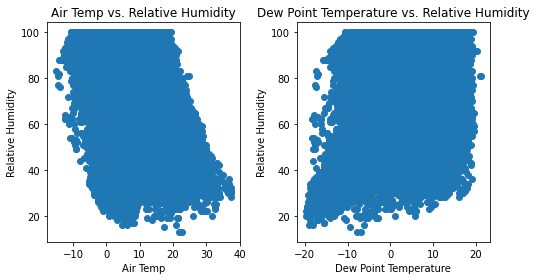

In [1]:
## Import some standard packages

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read/parse the input data
root_url = "Data/DELTA BURNS BOG.csv"
Data = pd.read_csv(root_url, low_memory=False)
Data = (Data[['TEMP', 'DEW_POINT_TEMP','RELATIVE_HUMIDITY']].dropna())

# Inspect the data
fig,ax = plt.subplots(1,2,figsize=(7,4))
ax[0].scatter(Data['TEMP'],Data['RELATIVE_HUMIDITY'])
ax[0].set_title('Air Temp vs. Relative Humidity')
ax[0].set_ylabel('Relative Humidity')
ax[0].set_xlabel('Air Temp')

ax[1].scatter(Data['DEW_POINT_TEMP'],Data['RELATIVE_HUMIDITY'])
ax[1].set_title('Dew Point Temperature vs. Relative Humidity')
ax[1].set_ylabel('Relative Humidity')
ax[1].set_xlabel('Dew Point Temperature')
plt.tight_layout()

# Mask the input data

RH is a non-linear function of Ta and Tdew
* To investigate the extrapolation capability of the models, we are going to mask out data where RH > 95%.
    * We can see how well the models perform on the training dat (RH < 95%) and the masked data (RH > 95%).


In [2]:
X_vars = ['TEMP', 'DEW_POINT_TEMP']
X_alias = ['Air Temp','Dew Point Temp']
Y_var = 'RELATIVE_HUMIDITY'
Y_alias = 'RH'

X_full = Data[X_vars].values
Y_full = Data[Y_var].values.reshape(-1,1)

x_mask = Data.loc[Data[Y_var]>=95,X_vars].values
x = Data.loc[Data[Y_var]<95,X_vars].values

y_mask = Data.loc[Data[Y_var]>=95,Y_var].values
y = Data.loc[Data[Y_var]<95,Y_var].values

print('Training Samples: ',y.shape)
print('Masked Samples: ',y_mask.shape)

Training Samples:  (40232,)
Masked Samples:  (26281,)


# Random Forest

The random forest is very simple to set up and it can be trained very fast with minimal computational overhead.  This makes them desireable for many applications (e.g., landscape classification).

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set 10% of training data aside for testing
# The RF model bootstraps the training data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)

# Time the run
T1 = time.time()
# Initialize the model
RF = RandomForestRegressor()
# Fit the model
RF.fit(x_train, y_train)
T2 = time.time()
print('Training Time: ', np.round(T2 - T1,2),' Seconds')


Training Time:  2.74  Seconds


### Validation

The RF performs very well on within the domain of the training data (RH < 95%), but the test data highlights extrapolation issues that RF models face.
* The model is incapable of making a projection beyond the bounds of the data it was trained on, which can result in erroneous estimates
    * This could be particularly problematic in high dimensional feature space where we cannot adequately visualize the domain of a training dataset

Validation Metrics: testing Data 
r2 =  0.9992 
RMSE =  0.22

Validation Metrics: Masked Data 
r2 =  0.0 
RMSE =  20.55


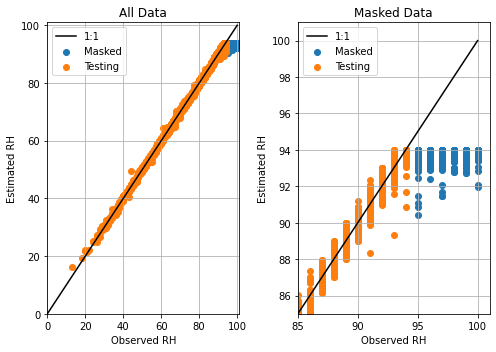

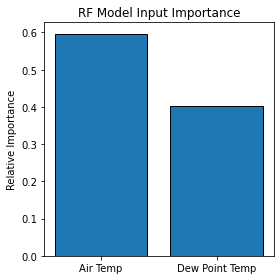

In [4]:
test = RF.predict(x_test)
Mask = RF.predict(x_mask)

fig,axes=plt.subplots(1,2,figsize=(7,5))
for ax in axes:
    ax.scatter(y_mask,Mask,label='Masked')
    ax.scatter(y_test,test,label='Testing')
    ax.plot([0,100],[0,100],color='k',label='1:1')
    ax.set_ylabel('Estimated '+Y_alias)
    ax.set_xlabel('Observed '+Y_alias)
    ax.grid()
    ax.legend()

axes[0].set_title('All Data')
axes[0].set_xlim(0,101)
axes[0].set_ylim(0,101)
axes[1].set_title('Masked Data')
axes[1].set_xlim(85,101)
axes[1].set_ylim(85,101)
plt.tight_layout()


R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

print()

R2 = metrics.r2_score(y_mask,Mask)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_mask,Mask)
print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

# Inspect the "feature importance"
# The relative weight of the input data in the model
fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_alias,RF.feature_importances_,edgecolor='k')
ax.set_ylabel('Relative Importance')
ax.set_title('RF Model Input Importance')
plt.tight_layout()

# Neural Network

* The NN ensemble is not as simple to set up - it requires the user to install more packages (e.g., Tensorflow) which can be tricky, and defining the model takes more time/consideration.

* Training is also considerably slower
    * This model is being run on a GPU which helps speed things up.  It can be run on a system without a suitable GPD, but processing on a CPU alone is **much slower**

* One NN is prone to over/under fitting, but an ensemble of NNs is more stable.  This is similar to the distinction between a random forest and a decision tree.
    * Ensembling increases accuracy but also increases training time.  This example uses an ensemble of n=30 randomly initialized networks trained on 30 randomly split iterations of the training data.


In [5]:
from tensorflow import keras
from keras.models import model_from_json
import json

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    dense1 = keras.layers.Dense(
        # 64,
        6,
        activation='relu',
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros"
    )(input_layer)
    output_layer = keras.layers.Dense(1)(dense1)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)


T0 = time.time()

N = 3

for i in range(0,N):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=42
        )
    if i == 0:
        Test_sets_x = [x_test]
        Test_sets_y = [y_test]
    else:
        Test_sets_x.append(x_test)
        Test_sets_y.append(y_test)

    T1 = time.time()
    model = make_model(input_shape=x_train.shape[1:])

    epochs = 250
    batch_size = 32

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "temp_files/model_weights"+str(i)+".h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=0),
    ]

    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )

    T2 = time.time()
    print('Network #'+str(i))
    print('Training Time: ', np.round(T2 - T1,2),' Seconds')
    print('')

    if i == 0:
        model_json = model.to_json()
        with open("temp_files/model_architecture.json", "w") as json_file:
            json_file.write(model_json)
    

print('\nFull Training Time: ', np.round(T2 - T0,2),' Seconds')

Network #0
Training Time:  46.58  Seconds

Network #1
Training Time:  61.73  Seconds

Network #2
Training Time:  30.28  Seconds


Full Training Time:  138.6  Seconds


# Validation

* The model is capable of extrapolating and making a reasonable guess at RH above 95% from Ta and Tdew without having been exposed to those conditions.

Prediction Time:  5.95  Seconds
Validation Metrics: testing Data 
r2 =  0.9992 
RMSE =  0.23

Validation Metrics: Masked Data 
r2 =  0.0 
RMSE =  4.29
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


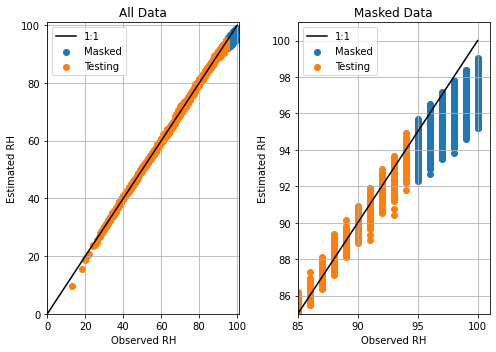

In [6]:
test = []
Mask = []


T1 = time.time()

with open("temp_files/model_architecture.json", 'r') as json_file:
    architecture = json.load(json_file)
    loaded_model = model_from_json(json.dumps(architecture))

for i in range(N):
    loaded_model.load_weights("temp_files/model_weights"+str(i)+".h5")
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
    
    test.append(loaded_model.predict(x_test))
    Mask.append(loaded_model.predict(x_mask))

T2 = time.time()

print('Prediction Time: ', np.round(T2 - T1,2),' Seconds')

test = np.array(test).mean(axis=0)
Mask = np.array(Mask).mean(axis=0)

fig,axes=plt.subplots(1,2,figsize=(7,5))
for ax in axes:
    ax.scatter(y_mask,Mask,label='Masked')
    ax.scatter(y_test,test,label='Testing')
    ax.plot([0,100],[0,100],color='k',label='1:1')
    ax.set_ylabel('Estimated '+Y_alias)
    ax.set_xlabel('Observed '+Y_alias)
    ax.grid()
    ax.legend()

axes[0].set_title('All Data')
axes[0].set_xlim(0,101)
axes[0].set_ylim(0,101)
axes[1].set_title('Masked Data')
axes[1].set_xlim(85,101)
axes[1].set_ylim(85,101)
plt.tight_layout()


R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

print()

R2 = metrics.r2_score(y_mask,Mask)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_mask,Mask)
print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

loaded_model.summary()


[[97.88653349 94.62661339 97.45443596]
 [98.5361546  94.95589238 98.10061519]
 [97.9662052  94.74075202 97.54931423]
 [97.89649245 94.64088072 97.46629575]
 [97.92636935 94.68368271 97.5018751 ]]


ValueError: Length of values (5) does not match length of index (66513)

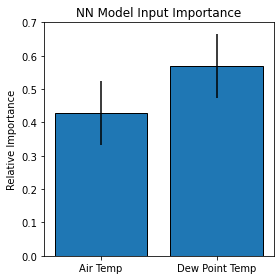

In [8]:

def Get_Weights(N):
    with open("temp_files/model_architecture.json", 'r') as json_file:
        architecture = json.load(json_file)
        # print(architecture)
        loaded_model = model_from_json(json.dumps(architecture))

    # Input layer
    W_i = []
    # Transposed Input layer
    W_i_T = []
    # Dense Input Layer
    W_d_i = []
    # Dense Output Layer
    W_d_o = []
    # Transposed Dense Output Layer
    W_d_o_T = []
    # Output Layer
    W_o = []

    for i in range(N):
        loaded_model.load_weights("temp_files/model_weights"+str(i)+".h5")
        W = loaded_model.get_weights()
        W_i.append(W[0])
        W_i_T.append(W[0].T)
        W_d_i.append(W[1])
        W_d_o.append(W[2])
        W_d_o_T.append(W[2].T)
        W_o.append(W[3])
    W_i = np.array(W_i)
    W_i_T = np.array(W_i_T)
    W_d_i = np.array(W_d_i)
    W_d_o = np.array(W_d_o)
    W_d_o_T = np.array(W_d_o_T)
    W_o = np.array(W_o)

    return(W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o)        

def get_Derivatives(N,X,y):
    W_i,W_i_T,W_d_i,W_d_o,W_d_o_T,W_o = Get_Weights(N)
    Op = []
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = (Ip*W_i_T).sum(axis=-1)+W_d_i
        # First derivative of the relu function
        # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
        H1 = np.maximum(H1,np.zeros(H1.shape))
        H2 = (H1*W_d_o_T).sum(axis=-1)+W_o
        Op.append(H2.diagonal())
    Estimates = np.array(Op)
    Cons = []
    Derivs = []
    for i in range(X.shape[1]):
        dj=[]
        for j in range(y.shape[0]):
            target = y[j]
            Xj = X[j][i]
            if np.isnan(target)==False:
                H1 = ((Xj*W_i[:,i,:]))+W_d_i
                AD = np.maximum(H1,np.zeros(H1.shape))
                AD[AD>0]=1
                Sum = np.array([AD[:,h]*W_d_o[:,h,0]*W_i[:,i,h] for h in range(W_d_o.shape[1])]).sum(axis=0)
                Sj = 1
                dj.append(Sj*Sum)
        dji = np.array(dj)
        Derivs.append(dji)
        Cons.append(np.sum(dji**2,axis=0))
    Derivs = np.array(Derivs)
    Cons = np.array(Cons)
    RIs = Cons/Cons.sum(axis=0)
    # Derivs = np.array(Derivs)
    return(RIs,Derivs,Estimates)
    
Relative_Importance,Derivatives,Estimates = get_Derivatives(N, X_full, Y_full)

RI_mean = Relative_Importance.mean(axis=1)
RI_se = Relative_Importance.std(axis=1)/Relative_Importance.shape[1]**.5



fig,ax=plt.subplots(figsize=(4,4))
ax.bar(X_alias,RI_mean,yerr=RI_se,edgecolor='k')
ax.set_ylabel('Relative Importance')
ax.set_title('NN Model Input Importance')
plt.tight_layout()

print(Estimates)

Model_Derivatives = pd.DataFrame(Derivatives.mean(axis=-1).T, columns = ['dRH_d'+x for x in X_vars])
Model_Derivatives_se = pd.DataFrame(Derivatives.std(axis=-1).T/Derivatives.shape[-1]**.5, columns = ['dRH_d'+x+'_se' for x in X_vars])
Model_Derivatives['RH_estimated'] = Estimates
Model_Derivatives['RH'] = Y_full
Model_Derivatives[X_vars] = X_full

Model_Derivatives.describe()

In [194]:

def get_Derivatives(loaded_model,X,y):
    W = loaded_model.get_weights()
    Op = []
    wi = W[0]
    wc = W[1]
    wo = W[2]
    nh = W[2].shape[0]
    Z = np.zeros(nh)
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = (((Ip*W[0].T)).sum(axis=1)+W[1])
        # First derivative of the rulu function
        # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
        H1 = np.maximum(H1,np.zeros(H1.shape[0]))
        H2 = (H1*W[2].T).sum()+W[3]
        Op.append(H2)
        print(H2)
    Estimate = np.array(Op)
    Cons = []
    Derivs = []
    for i in range(X.shape[1]):
        dj=[]
        for j in range(1):#y.shape[0]):
            target = y[j]
            output = float(Op[j])
            Xj = X[j][i]
            if np.isnan(target)==False:
                H1 = ((Xj*wi[i,:]))+wc
                # print(H1.shape)
                # First derivative of the relu function
                # If using sigmoid function, switch to - H1 = 1/(1+np.exp(-H1)) ; AD = H1*(1-H1)
                AD = np.maximum(Z,H1)
                AD[AD>0]=1
                Sum = np.array([wo[h]*AD[h]*wi[i,h] for h in range(nh)]).sum()
    #             # print(Sum)
    #             # print()
                Sj = 1
                dj.append(Sj*Sum)
        dji = np.array(dj)
    # #     # dji = YStandard.inverse_transform(np.array(dj).reshape(-1,1)).flatten()
        Derivs.append(dji)
        Cons.append(np.sum(dji**2))
    Cons = np.array(Cons)
    RI = Cons/Cons.sum()
    Derivs = np.array(Derivs)
    return(RI,Derivs,Estimate)


T1 = time.time()
Relative_Importance,Model_Derivs,Model_Outputs = [],[],[]

with open("temp_files/model_architecture.json", 'r') as json_file:
    architecture = json.load(json_file)
    loaded_model = model_from_json(json.dumps(architecture))

Model_Ensemble = []
for i in range(N):
    loaded_model.load_weights("temp_files/model_weights"+str(i)+".h5")
    Weights = loaded_model.get_weights()
    get_Derivatives(loaded_model, X_full, Y_full)
    print()
#     Outputs = get_Derivatives(loaded_model, X_full, Y_full)
#     Relative_Importance.append(Outputs[0])
#     Model_Derivs.append(Outputs[1])
#     Model_Outputs.append(Outputs[2])

# Relative_Importance=np.array(Relative_Importance).mean(axis=0)
# Model_Derivs=np.array(Model_Derivs).mean(axis=0)
# Model_Outputs=np.array(Model_Outputs).mean(axis=0)

# T2 = time.time()

# print('Inspection Time: ', np.round(T2 - T1,2),' Seconds')

# Model_Derivatives = pd.DataFrame(Model_Derivs.T, columns = ['dRH_d'+x for x in X_vars])
# Model_Derivatives['RH_estimated'] = Model_Outputs
# Model_Derivatives['RH'] = Y_full
# Model_Derivatives[X_vars] = X_full

# # Model_Derivatives.describe()

# fig,ax = plt.subplots(1,2,figsize = (7,5),sharey=True)
# ax[0].scatter(Model_Derivatives['TEMP'],Model_Derivatives['dRH_dTEMP'])
# ax[0].grid()
# ax[1].scatter(Model_Derivatives['DEW_POINT_TEMP'],Model_Derivatives['dRH_dDEW_POINT_TEMP'])
# ax[1].grid()

[97.83493]
[98.47559]
[97.913734]
[97.84478]
[97.87434]
[97.903885]
[97.86449]
[98.30813]
[98.28843]
[97.74628]
[98.583954]
[98.64306]
[98.71201]
[97.62771]
[93.64547]
[94.77903]
[95.873184]
[96.38579]
[96.92794]
[97.46024]
[97.42084]
[98.022095]
[97.47009]
[98.022095]
[98.05165]
[98.05165]
[98.0615]
[98.0418]
[98.022095]
[98.5938]
[98.64306]
[98.09105]
[98.64306]
[98.1009]
[98.130455]
[98.140305]
[98.76126]
[98.19941]
[98.77112]
[98.77112]
[98.228966]
[98.248665]
[98.238815]
[98.258514]
[98.29792]
[96.504]
[81.56085]
[86.65695]
[81.54115]
[86.627396]
[84.89258]
[84.88273]
[87.642746]
[86.528885]
[87.662445]
[85.35593]
[83.64081]
[84.82362]
[72.975426]
[77.58847]
[79.28388]
[76.494316]
[69.65356]
[65.77355]
[72.95573]
[89.83106]
[93.00517]
[94.02052]
[95.814445]
[96.22854]
[96.19898]
[96.26794]
[96.36645]
[96.30734]
[96.78054]
[97.29314]
[97.302986]
[97.28329]
[97.29314]
[96.87904]
[96.8889]
[96.87904]
[96.967705]
[97.74628]
[91.60528]
[77.421005]
[75.144035]
[63.709496]
[75.53843]
[88

: 

: 

In [127]:


def Derivatives(file,params,X,y):
    # time.sleep(2)
    import json
    try:
        with open(params['Spath']+params['Sname']+'.json', 'r') as json_file:
            # loaded_model = model_from_json(json_file.read())
            architecture = json.load(json_file)
            # loaded_model = model_from_json(architecture)
            loaded_model = model_from_json(json.dumps(architecture))
    except:
        try:
            time.sleep(10)
            with open(params['Spath']+params['Sname']+'.json', 'r') as json_file:
                # loaded_model = model_from_json(json_file.read())
                architecture = json.load(json_file)
                # loaded_model = model_from_json(architecture)
                loaded_model = model_from_json(json.dumps(architecture))
        except:
            pass
    loaded_model.load_weights(params['Spath']+params['Sname']+str(file)+'.h5')
    W = loaded_model.get_weights()
    if params['Loss'] =='Boot_Loss':
        loaded_model.compile(loss=Boot_Loss, optimizer='adam')
    elif params['Loss']=='Variance_Loss':
        loaded_model.compile(loss=Variance_Loss, optimizer='adam')
    else:
        loaded_model.compile(loss=params['Loss'], optimizer='adam')

    YStandard = joblib.load(params['Spath']+"Y_scaler.save")
    Op = []
    wi = W[0]
    wc = W[1]
    wo = W[2]
    nh = W[2].shape[0]
    Z = np.zeros(nh)
    for i in range(X.shape[0]):
        Ip = X[i]
        H1 = (((Ip*W[0].T)).sum(axis=1)+W[1])
        # print(H1.shape)
        if params['Activation'] == 'relu':
            H1 = np.maximum(H1,np.zeros(H1.shape[0]))
            # AD = np.maximum(Z,H1)
            # AD[AD>0]=1
        if params['Activation'] == 'sigmoid':
            H1 = 1/(1+np.exp(-H1))
        #     AD = H1*(1-H1)
        # print(AD)
        H2 = (H1*W[2].T).sum()+W[3]
        Op.append(H2)
    y = YStandard.transform(y.reshape(-1,1))
    Op = np.array(Op)#YStandard.inverse_transform(np.array(Op).reshape(-1,1))
    Cons = []
    # print(wi.shape,wc.shape,wo.shape)
    Derivs = []
    # print(X.shape)
    for i in range(X.shape[1]):

        dj=[]

        for j in range(y.shape[0]):
            target = y[j]
            output = float(Op[j])
            Xj = X[j][i]
            if np.isnan(target)==False:
                H1 = ((Xj*wi[i,:]))+wc#[i]
                if params['Activation']=='relu':
                    AD = np.maximum(Z,H1)
                    AD[AD>0]=1
                else:
                    H1 = 1/(1+np.exp(-H1))
                    AD = H1*(1-H1)
                # print(wo,AD,H1,wi,wc)
                Sum = np.array([wo[h]*AD[h]*wi[i,h] for h in range(nh)]).sum()
                # print(Sum)
                # print()
                Sj = 1
                dj.append(Sj*Sum)
        dji = np.array(dj)
        # dji = YStandard.inverse_transform(np.array(dj).reshape(-1,1)).flatten()
        Derivs.append(dji)
        Cons.append(np.sum(dji**2))
    Cons = np.array(Cons)
    Derivs = np.array(Derivs)
    return(Cons,Derivs,Op)

(4024, 1)
Validation Metrics: testing Data 
r2 =  0.9994 
RMSE =  0.16
Validation Metrics: Masked Data 
r2 =  0.2991 
RMSE =  2.05


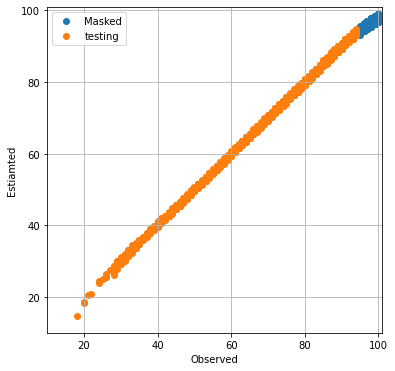

In [26]:
test = []
Mask = []

for i in range(0,N):
    model.load_weights("best_model"+str(i)+".h5")
    test.append(model.predict(x_test))
    Mask.append(model.predict(x_mask))

test = np.array(test).mean(axis=0)
Mask = np.array(Mask).mean(axis=0)

print(test.shape)

R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

R2 = metrics.r2_score(y_mask,Mask)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_mask,Mask)
print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

plt.figure(figsize=(6,6))
plt.scatter(y_mask,Mask,label='Masked')
plt.scatter(y_test,test,label='testing')
plt.ylabel('Estiamted')
plt.xlabel('Observed')
plt.xlim(10,101)
plt.ylim(10,101)
plt.grid()
plt.legend()
